# Fixed Effects Regression


## Intuition
Fixed effects has a simple intuitive explanation. Let's imagine you're trying to compare basketball players. Some are taller than the others. We think that there might be some sort of general relationship with height and statistics so that the average player who is 6'8" will have a fixed amount of rebounds they'll get more than a short player, who is 5'8".

We want to compare the two together, but we assume there is some sort of inherent difference between the players. In order to do this, we can just remove the average from our results. The key insight is that these effects **don't change** over time.

## Explanation 1: De-meaning

Let's start with a linear regression 

$$
y_{i,t} = X_{i,t}\beta + \alpha_i + u_{i,t}
$$

- $y$ is the dependent variable
- $X_{i,t}$ is the time-variant $1 \times k$ vector
- $\beta$ is the $k \times 1$ matrix of parameters
- $\alpha_i$ is the unobserverd time-invariant individual effect
- $u_{i,t}$ is the error term

Now, for a fixed effects regression, we assume that the $\alpha$ term is constant across time for all individuals. This means something like an advantage for being tall. Or specific characteristics related to somebody. If we want to remove the average effects, we can take out the mean from each variable, which will elimiate the fixed effect.

$$
y_{i,t} - \bar{y}_i = (X_{i,t} - \bar{X}_i)\beta + (\alpha_{i,t} - \bar{\alpha}_i) + (u_{i,t} - \bar{u}_i)
$$

Let's think, of what happened.
1. The "fixed effect" of $\alpha$ has dropped out of the equation.
2. The terms $u$ ,$X$, and $y$ have now been "de-meaned," and only the non-fixed effects relationship remains

$$
\ddot{y}_{i,t} = \ddot{X}_{i,t}\beta + \ddot{u}_{i,t}
$$

## Explanation 2: Dummy Variables
In this case, our estimates of beta are the same as our estimates if we were to use dummy variables. For instance,

$$
y_{i,t} = X_{i,t}\beta + \beta_i dummy_i + u_{i,t}
$$

is the same as our fixed effect regression. Why is this the case? It's because each of our dummy variables contains the *average* effects for each dummy variable. We can then get estimates of what each dummy effect is.

Now, the difference between fixed effects regressions and dummy variable regressions are the standard errors of the $\beta$ estimates.

Also, a fixed effect regression will preserve the values of the constant term, and the $R^2$ term.

## Analysis
One of the *so-what* implications of dummy variables and fixed effects is that it highlights that linear regressions are really about averages. Our beta estimats show the average difference a variable has on our model.

## Example
### Data Setup

Let's try to understand the effect of a beer tax on a state's fatality rate. We can assume that the fatality rate is different for each state. We can thing of this as a *fixed effect*.

$$
\textrm{Student Attrition}_{i,t} = \beta \times \textrm{Counselors per School}_{i,t} + \textrm{State FE} + u_{i,t}
$$

Let's start by creating random observational data, and we'll reconstruct our estimates. We'll create a random fatality rate, and a random beer tax rate. Our *true* functional form 

$$
\textrm{Student Attrition}_{i,t} = -0.06 \times \textrm{Counselors per School}_{i,t} + \textrm{State FE} + u_{i,t}
$$

We can now generate our *true* data by creating our *fixed effects* and our tax effect. Let's say that this has to do with unobserved *fixed* attributes of each state (e.g. cultural norms about dropping out, state funding structure, community education levels, etc.), such that NY would be different from CA in predictable ways. 

We want to have one row represent fatalities by state/year. Let's make 10 years of data.

In [1]:
import numpy as np
import pandas as pd

# set random parameters
np.random.seed(123)
n = 15

# lookup table for our "fixed" effects
effects = {
    'tx': 0.05,
    'ca': 0.07,
    'ny': -0.02,
    'nj': 0.03,
    'la': 0.10,
    'al': 0.11,
    'ms': 0.19,
    'az': 0.02,
    'me': -0.03,
    'ak': 0.01,
    'hi': -0.03
}

# create an iid variable  for our fatality_rand and tax
states = np.concatenate([[x] * n for x in list(effects.keys())])
ones = np.ones_like(states)
counselors = np.random.randint(50, 150, size=len(states)) / 100 + .1
effects = np.array([effects[x] for x in states])
noise = np.random.randn(len(states)) / 30

# let's create our linear model
X_hidden = np.array([ones, counselors, effects, noise]).T.astype(float)
B_hidden = np.array([0.09, -0.025, 0.4, 0.5])
y = X_hidden @ B_hidden

assert y.min() > 0

We'll create a pandas dataframe that has all the data we can observe, that is:
1. Student Attrition
2. Avg. # of Counselors
3. State

In [2]:
# create observational dataset
obs_df = pd.DataFrame(np.array([y, counselors]).T, columns=['student_attrition', 'counselors'])
obs_df['state'] = states
obs_df['const'] = 1

### Exploration

Let's first visualize our data

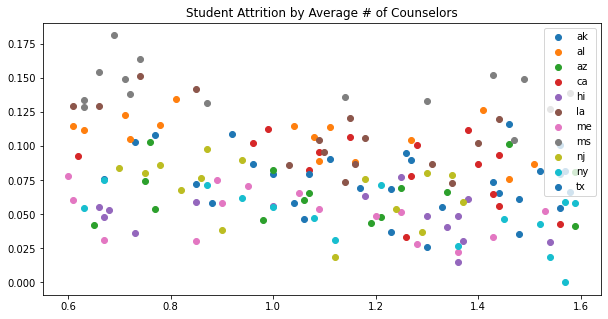

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

for l, data in obs_df.groupby('state'):
    ax.scatter(data.counselors, data.student_attrition, label=l)
    ax.set_title('Student Attrition by Average # of Counselors')

plt.legend()
plt.show()

We can see that there are differences in fatality rate. Some states tend to be higher, others lower. But in general, we can see basically no trend. If anything, it's *slightly negative*, but the variance in the data makes it hard for us to say definitively.

In [4]:
print("Summary of Student Attrition by Average # of Counselors")
print("-" * 50)
print()
print(round(obs_df.groupby('state').mean()[['student_attrition', 'counselors']], 2))

Summary of Student Attrition by Average # of Counselors
--------------------------------------------------

       student_attrition  counselors
state                               
ak                  0.07        1.16
al                  0.11        1.03
az                  0.07        1.11
ca                  0.08        1.22
hi                  0.05        1.11
la                  0.11        1.08
me                  0.05        1.04
ms                  0.14        1.04
nj                  0.07        1.03
ny                  0.05        1.21
tx                  0.08        1.27


### Initial Approach: Simple OLS
We might first want to understand what effect adding counsers has on the student attrition. While we can use the methods for linear regression which we've calculated earlier, let's instead use the `statsmodels` package to run our OLS regressions.

In [5]:
import statsmodels.api as sm

y1 = obs_df['student_attrition']
y2 = obs_df[['const', 'counselors']]

first_reg = sm.OLS(y1, y2).fit()
print(first_reg.summary())

                            OLS Regression Results                            
Dep. Variable:      student_attrition   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     12.76
Date:                Tue, 05 May 2020   Prob (F-statistic):           0.000466
Time:                        15:17:55   Log-Likelihood:                 327.74
No. Observations:                 165   AIC:                            -651.5
Df Residuals:                     163   BIC:                            -645.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1139      0.010     11.303      0.0

We can see that this approach over-estimates the effect of counselors. This is because the states have various fixed effects. However, it's worth noting that the estimates for counselors and our constant are directionally correct. The true value of tax (-0.025) lies within the confidence interval of tax, while the true value of our constant (0.09) is outside of our confidence interval. Let's see how our fixed effects regressions perform.

###  Approach 2: Fixed Effects - De-meaned
The intuitive way of understanding fixed effects is *de-meaning* the group data. This means, grouping data by each state, taking the average of each value, and subtracting that value from our data.

In [6]:
# de-mean the data
demeaned = (obs_df.groupby('state')
                  [['student_attrition', 'counselors']]
                  .apply(lambda x: x - x.mean()))

# run our regression
y2 = demeaned[['student_attrition']]
x2 = demeaned[['counselors']]
x2['const'] = 1
reg2 = sm.OLS(y2, x2).fit()

print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:      student_attrition   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     25.51
Date:                Tue, 05 May 2020   Prob (F-statistic):           1.17e-06
Time:                        15:17:55   Log-Likelihood:                 424.96
No. Observations:                 165   AIC:                            -845.9
Df Residuals:                     163   BIC:                            -839.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
counselors    -0.0253      0.005     -5.050      0.0

We can see that we have recovered the true coefficient for *tax*. However, we have no estimate for our constant. This is because our demeaning process 

### Approach 3: Fixed Effects - Dummies

In [7]:
# run our regression
y3 = obs_df.student_attrition
x3 = pd.concat([obs_df[['const', 'counselors']], pd.get_dummies(obs_df.state)], sort=True, axis=1)
reg3 = sm.OLS(y3, x3).fit()

print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:      student_attrition   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     34.83
Date:                Tue, 05 May 2020   Prob (F-statistic):           3.33e-36
Time:                        15:17:55   Log-Likelihood:                 424.96
No. Observations:                 165   AIC:                            -825.9
Df Residuals:                     153   BIC:                            -788.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0985      0.005     17.959      0.0

We see that adding dummy variables in our regression allow us to interpret the constant and tax correctly. Also, we have more accurate standard errors from our estimates. We can see that either demeaning or controlling for factors allows us to make better interpretations.

It might be tempting to look at the $R^2$ of this model and generally assume that it's better, so we can trust the coefficients more. But in reality, it doesn't tell us anything about coefficient significance. So in our case, we get the same estimate from de-meaning as including dummy variables. We should keep this in mind when understanding what aggregate effect dummy variables may have.